# Molecular dynamics analysis of the BCL-xl APO form

## Installation & Import

The MDAnalysis package can be isntall with:
-   ```bash
    conda install -c conda-forge mdanalysis
    ```
-   ```bash
    pip install MDAnalysis
    ```

Optional packge for the visualization of the protein `nglview`:
-   ```bash
    conda install -c conda-forge nglview
    ```
-   ```bash
    pip install nglview
    ```

In [2]:
import MDAnalysis as mda
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/sdv/m2isdd/pho/.conda/envs/md-analysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This tutorial was done with the vesrion 2.7.0, last uptdate Feb, 2024

## MDAnalysis Basics

### Universe

Structure in two class:  
-   `Universe`
-   `AtomGroup`  

Every analysis have to start by the definition of the `Universe` which contains all the informations describing a MD system.

To load the universe:  
  
```python
u = mda.Universe("topology_file", "trajectory_file")

# Use one file
# In that case the PDB file is considere as both topology and trajectory
u = mda.Universe("PDB_file")

# Use a list of trajectory
u = mda.Universe("topology_file", [traj1, traj2, ... trajn])
```
  
The `Universe` has 2 key proterties:  
-   `atoms` (belong the `AtomGroup` class) ==> provide access to important analysis
-   `trajectory` ==> Contain the trajectory
    -   The advantage of MDAnalys is that not all the trajectory is charged saving memory space

The `Universe` allows to link between:
-   topologies files ==> Statics information of the atoms
    -   Namen mass, type
    -   Covalent bonds (connectivity table)
    -   angles and dihedrals
    -    ...
    - format:
        - Gromax: `.tpr`
        - PDB
-   trajectory ==> dynamic information
    -   atoms coordinates for each frame ($\delta$ t)
    -   velocity, force, box dimension
    -   With gromax it is a binary format
        - output: `file.xtc`

Notice:
-   The trajoectory must have the coordinates in the sames order than the topology file
-   MDAnalysis stores trajectories using its internal units: Å (ångström) for length and ps (picosecond) for time, regardless of the original MD data format.

In [3]:
topology_file = "nvt_onlyProt.gro"
trajectory_file = "mb_0_1_noPBC_onlyprot.xtc"

u = mda.Universe(topology_file, trajectory_file)

/home/sdv/m2isdd/pho/.conda/envs/md-analysis/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [4]:
# Check the time step ps
u.trajectory.dt

10.0

In MDAnalysis the Universe is divide in container as follow:  
- `Segment` > `Résidu` > `Atoms`

Every object belongs to its own class:
- `Segment` --> `SegmentGroup`
- `Residue` --> `ResidueGroup`
- `Atoms`--> `AtomGroup`

Object of the Universe:

In [5]:
# All atoms in the system
u.atoms

<AtomGroup with 2661 atoms>

*This object belong to `AtomGroup` class* 

In [6]:
# All Residues in the system
u.residues

<ResidueGroup with 170 residues>

In [7]:
# All segments in the system
u.segments

<SegmentGroup with 1 segment>

All bonds, angles, dihedrals & impropers in the system as `TopologyObjects` if there are these information

```python
u.bonds
u.angles
u.dihedrals
u.impropers
```

Possibility to create a universe from differents `AtomGroup` class

```python
from MDAnalysis.core.universe import Merge()

u1 = mda.Universe("PDB_file1")
u2 = mda.Universe("PDB_file2")
u = Merge(u1.atoms, u2.atoms)
```

### AtomGroup

An `Universe` contain all the particlue of the system.  
A particlue is called **atom** whether it really is ==> e.g. coarse grain bead

A selection of **Atoms** are grouped in an `AtomGroup`. This class is the most important object in MDAnlysis since everything is accessible through it.

#### Selection of AtomGroup

##### Selection by keywords

An `AtomGroup` can be selected with keywords and the function `.selecte_atoms("keyword selection")`  

Some notable important keywords selection:
-   `protein` ==> Select all atoms of the protien
-   `backbone` ==> Select only the backbone atoms of the protein
    -   Atom's name: CA, C, O, N
-   `resname RESIDUE_NAME` ==> All atom of all the given residue ex: `resname GLY`
-   `resnum` ==> All atom on a single or a range of residue
    -   Single residue: `resnum 1`
    -   Range, 2 number separate by `:` **inclusive**: `resnum 1:5`
-   `name ATOM_NAME` ==> All atom with the same name ex: `name CA`

All string selection as `resname` and `name` can be matches with Unix shell-style wildcards:
-   `*`select any character
-   `[seq]` select any acharacter in `seq`
-   `[!seq]` select any acharacter which are not in `seq`  
For exemple `GL*` give GLY, GLU, GLN, GLX29.... `GL[YN]` give only GLY & GLN.

Allows advance selection with booleans `̀not`, `adn`, `or`, read from left to right.
Parenthesis can by used.

In [8]:
ag1 = u.select_atoms("resname ARG")
ag2 = u.select_atoms("resname ARG and not (name H or name O)")
ag3 = u.select_atoms("resname ARG and not (name H* or name O)")
ag4 = u.select_atoms("(name H* or name O) and not resname ARG")

print(f"Number atoms in grǹumpyoupe 1: {len(ag1)}")
print(f"Number atoms in groupe 2: {len(ag2)}")
print(f"Number atoms in groupe 3: {len(ag3)}")
print(f"Number atoms in groupe 4: {len(ag4)}")


Number atoms in groupe 1: 264
Number atoms in groupe 2: 242
Number atoms in groupe 3: 110
Number atoms in groupe 4: 1305


Others type of selection like nucleic acid, geometric, dynamic selection... are possible.  
See the [Atom selection web page](https://userguide.mdanalysis.org/stable/selections.html#selections) for more information.

##### Selection by index

AtomGroup are indexacble and iterable:  
An particular atom can be return think to its index indected between bracket.

In [9]:
atom0 = u.atoms[0]  # First atom in the all universe
atom0

<Atom 1: N of type N of resname MET, resid 1 and segid SYSTEM>

A range of selection can be used with slicing (and steps) or by indexing a list:

In [10]:
ag1 = u.atoms[0:6:2]
print(f"Number of atoms in group 1: {len(ag1)} corresponding to the following indices: {ag1.indices}")

Number of atoms in group 1: 3 corresponding to the following indices: [0 2 4]


In [45]:
idx_list = [0, 2, 3, 10, -1, 3]
ag2 = u.atoms[idx_list]
print(f"Number of atoms in group 1: {len(ag2)} corresponding to the following indices: {ag2.indices}")

Number of atoms in group 1: 6 corresponding to the following indices: [   0    2    3   10 2660    3]


*Note:*
-   *The methode `.indices` returns the indeces of the selected atoms in the `AtomGroup` object as an numpy ndarray*
-   *It is possible to select two times or more the same atom*

In [15]:
type(ag2.indices)

numpy.ndarray

Creation of a group via a list of atom and the function `AtomGroup()`

In [55]:
atom1 = u.atoms[10]
atom2 = u.atoms[100]
atom3 = u.atoms[1000]
list_atoms = [atom1, atom2, atom3]
ag3 = mda.AtomGroup(list_atoms)

In [56]:
for atom in ag3:
    print(atom)
    

<Atom 11: HG1 of type H of resname MET, resid 1 and segid SYSTEM>
<Atom 101: CB of type C of resname GLU, resid 7 and segid SYSTEM>
<Atom 1001: NH1 of type N of resname ARG, resid 63 and segid SYSTEM>


#### Group operator and set methods

Group operator and set operator acheive similar outcome: compare and construc new groups from differents `AtomGroup`.
-   Group operator:
    -   `+`, `.concatenate()`, `-`, `.substract()`
    -   Keep all atoms of the two groups, preseveing the order of each groups

In [46]:
# New group with element of all elements from ag1 & from ag2
plus = ag1 + ag2
concat = ag1.concatenate(ag2)
print(f"ag1: {ag1.indices}")
print(f"ag2: {ag2.indices}")
print(f"plus: {plus.indices}")
print(f"concat: {concat.indices}")


ag1: [0 2 4]
ag2: [   0    2    3   10 2660    3]
plus: [   0    2    4    0    2    3   10 2660    3]
concat: [   0    2    4    0    2    3   10 2660    3]


In [53]:
# New group with element of all elements from ag2 that are not in ag1
subs = ag2.subtract(ag1)
print(f"substrate: {subs.indices}")

substrate: [   3   10 2660    3]


-   Set methods
    -   `|`, `.union()`, `.difference()`
    -   Return **UNIQUE** and **topology ORDERED** `AtomGroup`

In [48]:
# Union: Element from both ag1 and ag2
uni_symbol = ag1 | ag2
uni_function = ag1.union(ag2)
print(f"ag1: {ag1.indices}")
print(f"ag2: {ag2.indices}")
print(f"uni_symbol: {uni_symbol.indices}")
print(f"uni_function: {uni_function.indices}")


ag1: [0 2 4]
ag2: [   0    2    3   10 2660    3]
uni_symbol: [   0    2    3    4   10 2660]
uni_function: [   0    2    3    4   10 2660]


In [54]:
# Difference: In ag1 but not in ag2
minus_1_2 = ag1 - ag2
dif_1_2 = ag1.difference(ag2)
print(f"minus 1-2: {minus_1_2.indices}")
print(f"dif 1-2: {dif_1_2.indices}")

# In ag2 but not in ag1
minus_2_1 = ag2 - ag1
dif_2_1 = ag2.difference(ag1)
print(f"minus 2-1 : {minus_2_1.indices}")
print(f"dif 2-1: {dif_2_1.indices}")


minus 1-2: [4]
dif 1-2: [4]
minus 2-1 : [   3   10 2660]
dif 2-1: [   3   10 2660]


*Remark: The order is important !*

In [52]:
# Intersection: Element common in ag1 and ag2
and_symb = ag1 & ag2
inter = ag1.intersection(ag2)
print(f"and_symb : {and_symb.indices}")
print(f"inter : {inter.indices}")

and_symb : [0 2]
inter : [0 2]


### Trajectory

MDAnalysis does not load all the frame of the trajectory in order to save the memory.  
The universe has a state wiht a particular time step associated to a trajectory.  
When the time step change ==> Data associted shifts also

Every time step is indexed to a list accessible trough the `.trajectory`

In [61]:
print(type(u.trajectory))
print(len(u.trajectory))
print(f" First time setp: {u.trajectory[0]};\n Last time step: {u.trajectory[-1]}")

<class 'MDAnalysis.coordinates.XTC.XTCReader'>
5674
 First time setp: < Timestep 0 with unit cell dimensions [88.99272 88.99272 88.99272 90.      90.      90.     ] >;
 Last time step: < Timestep 5673 with unit cell dimensions [89.05934 89.05934 89.05934 90.      90.      90.     ] >


In fact, the universe keep in memory only the last time step call

In [71]:
u.trajectory[1]
print(f"Time of the 1st frame: {u.trajectory.time} ps")
u.trajectory[10]
print(f"Time of the 10th frame: {u.trajectory.time} ps")
u.trajectory[100]
print(f"Time of the 100th frame: {u.trajectory.time} ps")
u.trajectory[-1]
print(f"Time of the last frame: {u.trajectory.time} ps")

Time of the 1st frame: 10.0 ps
Time of the 10th frame: 100.0 ps
Time of the 100th frame: 1000.0 ps
Time of the last frame: 56730.0 ps


Trajectory can also be sliced in order to work only on a part of the simulation

In [69]:
for ts in u.trajectory[:500:100]:
    print(f"frame: {ts.frame:>3}, time: {ts.time:>5.0f} ps")

frame:   0, time:     0 ps
frame: 100, time:  1000 ps
frame: 200, time:  2000 ps
frame: 300, time:  3000 ps
frame: 400, time:  4000 ps


## Analysis

The main goal of this package is to analyse trajectory of Molecular Dynamic Simulation.
The module MDanalysis.analysis contain all the dependecies for the analys e.g. rmsd, align...

### Alignment

Since the protein moves inside the box, it is mandatory to align the structure duricng the trajectory with a reference one (e.g. the 1st frame)  
This action can be done with the function `.AlignTraj` of the dependecie `align`

In [7]:
from MDAnalysis.analysis import align

/home/sdv/m2isdd/pho/.conda/envs/md-analysis/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


Since MDAnalysis does not conserved the information when the frame is changed, the method `.AlignTraj` enable to save the new trajectory in a other file.  
If the trajectory is not save, the method will have not effect on the original one.  

In [9]:
ref = u.copy()  # Make a copy to conserve the original trajectory
                # If no copy ==> The trajectory of the reference can be modified during the alignment

In [80]:
ref.trajectory[0]  # Select te reference frame
align.AlignTraj(u,  # Trajectory to align
                ref,   # Reference frame
                select = "name CA",  # Alignment on the CA 
                filename = "aligned.dcd",  # File to write the new trajectory
                match_atoms = True,  # whether to match atms based on mass
                ).run()


Now the aligned trajecteory is saved in a new file, however the last orignal has conserved its caracteristics

In [81]:
# Load the aligned trajectroy in the new unverse
aligned_u = mda.Universe("npt_onlyprot.gro", "aligned.dcd")

/home/sdv/m2isdd/pho/.conda/envs/md-analysis/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


It is possible to not write into a file by loading all the trajectory in the memory. This is not a always deasible in case of the big files.

In [10]:
aligner = align.AlignTraj(u, ref,
                          select='name CA',
                          in_memory=True).run()

This object enable to align all the trajectory of the universe in place. Now all the frame of the unverse are aligned and the calculation of the RMSD and the RMSF can be performed directly.  
It can be notice that the code create an object which has a unique function to align the the universe. Chaining method is used to run the alignement, it is equivalent to `aligner.run()`

### RMSD

$\text{RMSD} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left( \left( x_i^{\text{ref}} - x_i^{\text{traj}} \right)^2 + \left( y_i^{\text{ref}} - y_i^{\text{traj}} \right)^2 + \left( z_i^{\text{ref}} - z_i^{\text{traj}} \right)^2 \right)}$


In [11]:
# Import
from MDAnalysis.analysis import rms

For the calcul of the RMSD, the superposition of the structure is mandatory since the protein can move inside the box. The function `.RMSD()` can perform this alignement with a given reference. So it is not usefull to performed the previous alignment.

In [12]:
# RMSD analysis
rmsd_analysis = rms.RMSD(u,  # Univers to align
                u,  # Universe of the reference
                select = "backbone",  # Group to superimpose and calculate RMSD
                ref_frame = 0)  # frame index of the reference
rmsd_analysis.run()

If the alignment has already done, the RMSD can be calculated directly on the unverse:

In [13]:
rmsd_analysis = rms.RMSD(u, select="backbone").run()

Results are saved in rmsd_analysis.rmsd as an array([frame, time (ns), selections])

In [14]:
rmsd_analysis.results.rmsd[1]

array([ 1.        , 10.        ,  0.98493067])

In [17]:
# Store the rmsd in a dataframe
rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd, columns= ["Frame", "Time", "Backbone"])
rmsd_df.tail()

,Frame,Time,Backbone
5851,5851.0,58510.0,4.667360
5852,5852.0,58520.0,4.750067
5853,5853.0,58530.0,4.584274
5854,5854.0,58540.0,4.528981
5855,5855.0,58550.0,4.667133


<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_439665/1300453044.py:4: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSD ($\AA$)')


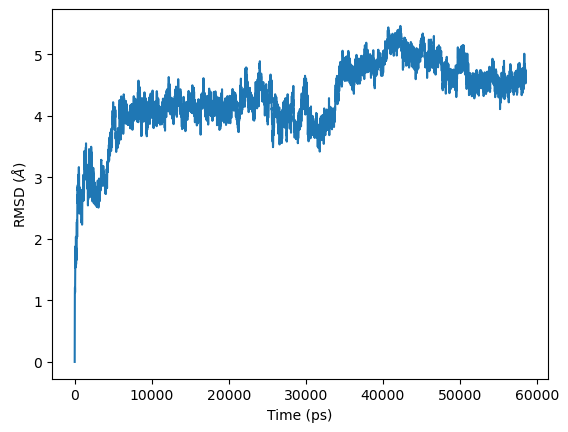

In [18]:
# PLot the RMSD
plt.plot(rmsd_df["Time"], rmsd_df["Backbone"])
plt.xlabel('Time (ps)')
plt.ylabel('RMSD ($\AA$)')
plt.show()

### RMSF

$\text{RMSF}_i = \sqrt{\frac{1}{N} \sum_{t=1}^{N} \left( \left( x_i(t) - \langle x_i \rangle \right)^2 + \left( y_i(t) - \langle y_i \rangle \right)^2 + \left( z_i(t) - \langle z_i \rangle \right)^2 \right)}$


Analysis of the RMSF which was previoulsy aligned.  
The fluctuation is measured by the comparison of the $C\alpha$

In [19]:
c_alphas = u.select_atoms('protein and name CA')
rmsf_analysis = rms.RMSF(c_alphas).run()

<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_439665/1215325940.py:3: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSF ($\AA$)')


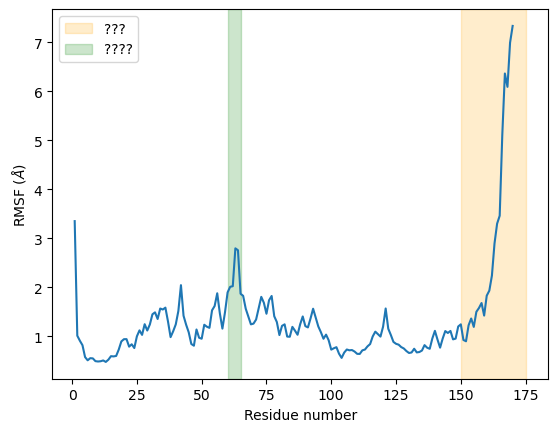

In [20]:
plt.plot(c_alphas.resids, rmsf_analysis.results.rmsf)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')
plt.axvspan(150, 175, zorder=0, alpha=0.2, color='orange', label='???')
plt.axvspan(60, 65, zorder=0, alpha=0.2, color='green', label='????')
plt.legend()

### Radius of Giration

The radius of giration measure how the protein is compact, it can be calculated like this:

$\mathbf{r}_{\text{cm}} = \frac{\sum_{i=1}^{N} m_i \mathbf{r}_i}{\sum_{i=1}^{N} m_i}$

There is no method which caclulate the radius of gyration for all the frame of the simulation. It have to be calculated one by one.

In [23]:
time = []
rgyr = []  # Radius of gyration

protein = u.select_atoms("protein")

for _ in u.trajectory:  # iterate through all frames
    time.append(u.trajectory.time)
    
    # Use an AtomGroup method
    rgyr.append(protein.radius_of_gyration())
    
# Creation of the dataframe:
rgyr_df = pd.DataFrame(rgyr, columns = ["Radius_of_Gyration"] ,index=time)
rgyr_df.index.name = "Time"

<>:6: SyntaxWarning: invalid escape sequence '\A'
<>:6: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_439665/3237376077.py:6: SyntaxWarning: invalid escape sequence '\A'
  ax.set_ylabel("Radius of Gyration ($\AA$)")


Text(0, 0.5, 'Radius of Gyration ($\\AA$)')

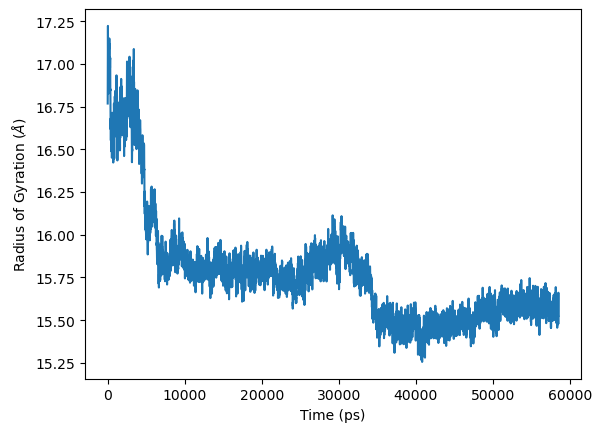

In [22]:
# Plot with Mathplotlib
fig, ax = plt.subplots()
ax.plot(rgyr_df)
ax.set_xlabel("Time (ps)")
ax.set_ylabel("Radius of Gyration ($\AA$)")